In [3]:
import numpy as np
from joblib import Parallel,delayed
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from joblib import load
from scipy.stats import pearsonr,spearmanr
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import glob
import os
import matplotlib.pyplot as plt



scores_df = pd.read_csv('./ChipQA/apv_livestream_scores.csv')
video_names = scores_df['video']
scores = scores_df['MOS']
#scores_df['content']=[ i[-9:] for i in scores_df['video'] ]


Text(0, 0.5, 'Count')

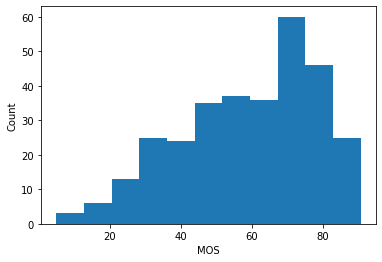

In [6]:
plt.hist(scores,bins='auto')
plt.xlabel('MOS')
plt.ylabel('Count')

In [4]:
# print(len(scores_df['content'].unique()))
srocc_list = []
test_zips = []

def find(lst, a):
    return [i for i, x in enumerate(lst) if x==a]

def single_run_svr(r):
    train,test = train_test_split(scores_df['content'].unique(),test_size=0.2,random_state=r)
    train_features = []
    train_indices = []
    test_features = []
    train_scores = []
    test_scores = []
    train_vids = []
    test_vids = []
    feature_folder= './features/fall21_hdr_chipqa_pq_upscaled_features'
    feature_folder2= './features/fall21_hdr_chipqa_global_logit_upscaled'

    for i,vid in enumerate(video_names):
        featfile_name = vid+'_upscaled.z'
        score = scores[i]
        feature1 = np.asarray(load(os.path.join(feature_folder,featfile_name))['features'],dtype=np.float32)
        feature2 = np.asarray(load(os.path.join(feature_folder2,featfile_name))['features'],dtype=np.float32)
        feature = feature1
        feature = np.nan_to_num(feature)
#        if(np.isnan(feature).any()):
#            print(vid)
        if(scores_df.loc[i]['content'] in train):
            train_features.append(feature)
            train_scores.append(score)
            train_indices.append(i)
            train_vids.append(vid)
            
        else:
            test_features.append(feature)
            test_scores.append(score)
            test_vids.append(vid)
    train_features = np.asarray(train_features)
    naninds =np.argwhere(np.isnan(train_features)) 
    nanshape = naninds.shape
#    for nanind in range(nanshape[0]):
#        actind = train_indices[nanind]
#        print(scores_df.loc[actind]['video'])
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(train_features)
    X_train = scaler.transform(train_features)
    X_test = scaler.transform(test_features)
    grid_svr = GridSearchCV(SVR(),param_grid = {"gamma":np.logspace(-8,1,10),"C":np.logspace(1,10,10,base=2)},cv=5)
    grid_svr.fit(X_train, train_scores)
    preds =grid_svr.predict(X_test)
    test_zip = list(zip(test_vids,test_scores,preds))
    return test_zip
#    test_zips.append(test_zip)
#
#
#    srocc_test = spearmanr(preds,test_scores)
#    print(srocc_test)
#    srocc_list.append(srocc_test[0])

# test_zips = Parallel(n_jobs=-1)(delayed(single_run_svr)(r) for r in range(100))



In [8]:
test_zips = load('./ChipQA/preds/luma_greenbrisque.z')
scores = []
names =[]
preds =[]
# print(np.median(srocc_list))
for v in test_zips:
    print(v)
    for l in v:
        names.append(l[0])
        scores.append(l[1])
        preds.append(l[2])
print(names)
print(scores)
nscores= []
npreds = []
nset = set(names)
print(len(names))
print(len(nset))
print(nset)
for n in nset:
    indices = find(names,n)
    nscores.append(np.mean([scores[i] for i in indices]))
    npreds.append(np.mean([preds[i] for i in indices]))
print(nscores,npreds)





IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[58.230083, 53.497246, 60.124493, 31.788729, 33.731045, 42.894463, 34.41217, 22.162441, 36.758995, 35.799427, 40.186832, 34.721867, 45.80525, 59.114933, 63.43614, 38.718697, 59.278873, 28.32184, 46.527256, 35.10682, 66.6429, 57.778683, 56.56165, 27.86391, 56.4883, 39.075542, 58.308292, 61.92524, 30.02585, 29.50721, 42.031822, 58.003593, 28.888247, 40.40063, 29.236942, 36.167294, 40.28207, 69.31221, 54.37016, 40.691, 43.12399, 52.49785, 28.501678, 37.396004, 50.491814, 49.4475, 62.810116, 24.764185, 58.717304, 26.259031, 48.478878, 56.479675, 56.81908, 36.97089, 26.663048, 38.695133, 60.83295, 41.172337, 36.43067, 33.28467, 29.548471, 64.16969, 66.013725, 38.834743, 66.528824, 26.131506, 59.79006, 58.004257, 46.959293, 62.594494, 40.359165, 35.95653, 66.60485, 66.923775, 58.905758, 24.706968, 49.586372, 63.653507, 45.387035, 42.788002, 37.65012, 48.462578, 58.987896, 62.082912, 40.177296, 63.51394, 42.367878, 56.25871, 58.818478, 50.20211, 52.66681, 65.99633, 43.309513, 43.455826, 43.42

-0.037250384024577546


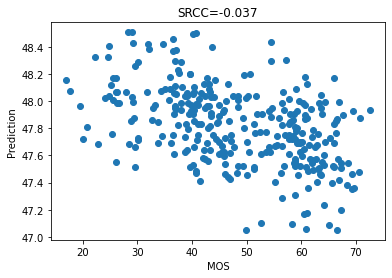

In [9]:
srcc_csv = pd.read_csv('./ChipQA/results/greenbrisque_srcc_lcc_rmse_list.csv')
print(np.median(srcc_csv['srcc']))

plt.scatter(nscores,npreds)
plt.title('SRCC='+str(np.median(srcc_csv['srcc']))[0:6])
plt.xlabel('MOS')
plt.ylabel('Prediction')

plt.savefig('./images/luma_greenbrisque.png')

0.1035186251920123
